# #Fiber Modes

In [466]:
import numpy as np
import os
from subprocess  import check_output
from matplotlib import pyplot as plt
import cmasher as cm
import re
from scipy.optimize import curve_fit

from scipy.special import jv as BesselJ
from scipy.special import kn as BesselK
from scipy.special import jvp as BesselJp
from scipy.special import kvp as BesselKp

In [8]:
def waveguide_modes(config, simulscript, cleanup=True, verbose=False):
    if 'comments' in config:
        comments = config['comments']
        del config['comments']
    else:
        comments = ''
    
    # Circuit files are just text files, so we can read them in
    simulscript_txt = open(simulscript, 'r').read()
    mode_dir = os.path.split(simulscript)[0]
    os.chdir(mode_dir)

    if 'polarization' in config:
        pol = {0:'TE', 1:'TM'}[config['polarization']]
    else:
        pol = None

    # Remove old mode files
    if cleanup:
        files = os.listdir(mode_dir)
        mode_files = [os.path.join(mode_dir,f) for f in files if re.match('[m,p]\d+', f.split('.')[-1])]
        for f in mode_files:
            os.remove(f)
    
    # Compute a few useful figures
    n_core = config['Core_index']
    n_cladding = config['Cladding_index']
    core_radius = config['Core_radius']
    wavelength = config['free_space_wavelength']
    NA = np.sqrt(n_core**2 - n_cladding**2)
    V_num = 2 * np.pi * core_radius / wavelength * NA
    numModes_approx = 4 * V_num**2 / np.pi**2
    if verbose:
        print('There should be about %.1f modes.' % numModes_approx)

    # Put together the command to run the simulation
    cmd = ['bsimw32', simulscript, 'wait=0']
    num_params = ['%s=%f' % (k, v) for k, v in config.items() if type(v) in [int, float, np.float64]]
    str_params = ['%s=%s' % (k, v) for k, v in config.items() if type(v) == str]
    cmd = cmd + num_params + str_params
    
    # Run it
    check_output(cmd, shell=True)

    # Query the filenames for the computed fields and effective refractive indices
    files = os.listdir(mode_dir)
    mode_files = [os.path.join(mode_dir,f) for f in files if re.match('m\d+', f.split('.')[-1])]
    try:
        nef_file = os.path.join(mode_dir, config['prefix']+'.nef')
        neffs = np.genfromtxt(nef_file)
        if len(neffs.shape) == 1:
            neffs = neffs.reshape((1,neffs.shape[0]))
        neffs = neffs[:,1:]
        neffs = neffs[:,0]+1j*neffs[:,1]
        if np.max(np.imag(neffs)) == 0:
            neffs = np.real(neffs)
        neffs = neffs.T
    except:
        neffs = None
    
    # Put all the output together in a dictionary
    output = {'neffs': neffs,
              'V':V_num,
              'NA':NA,
              'numModes_approx': numModes_approx,
              'mode_files': mode_files,
              'config': config,
              'simulscript': simulscript,
              'cmd': cmd,
              'simulscript_txt': simulscript_txt}
    
    # If there are comments put them back in the ouput
    if comments:
        output['comments'] = comments
    return output

def load_mode_data(filename):
    '''This function can be used to read
    the data stores in the output fiels from
    the Photonic Tools mode solver.
    
    Parameters
    ----------
    filename : str

    Returns
    -------
    extent (tuple), lines(np.array), n_eff (np.array)
    
    '''
    with open(filename, 'r') as f:
        lines = f.readlines()
        metadata = lines[:4]
        n_eff = metadata[2].split(' ')[5]
        output_type = lines[2].split(' ')[4]
        xmin, xmax = metadata[2].split(' ')[1:3]
        zmin, zmax = metadata[3].split(' ')[1:3]
        lines = lines[4:]
        lines = [line.strip() for line in lines]
        lines = [line.split() for line in lines]
        lines = [[float(x) for x in line] for line in lines]
        extent = (float(xmin), float(xmax), float(zmin), float(zmax))
    lines = np.array(lines).T
    if output_type == 'OUTPUT_REAL_IMAG_3D':
        lines_re = lines[0::2]
        lines_im = lines[1::2]
        if np.max(np.abs(lines_im)) == 0:
            lines = lines_re
        else:
            lines = lines_re + 1j*lines_im
    return extent, lines, n_eff

In [7]:
import numpy as np
n2 = 1.458
n1 = 1.4614
V = 2 * np.pi * np.sqrt(n1**2 - n2**2) * 0.5 / 0.633
print(V**2/2)

0.12224605429777247


In [ ]:
mode_dir = os.path.split(simulscript)[0]
files = os.listdir(mode_dir)
mode_files = [os.path.join(mode_dir,f) for f in files if re.match('m\d+', f.split('.')[-1])]

## ##Single Mode Fiber SM600

### ###Single Radius (scalar mode)

Radius of the core is not given in the spec sheet, this was approximated from their given MFD. However, this choice is not self-consistent. Also, it is not exactly clear what it is that they're quoting in the MFD. At the end this ends up being an example of a single-mode fiber, but not necessarily matching all of the ideal features of the SM600.

In [1]:
import os

In [704]:
config = {'mode_set':'0-19',
        'prefix':'SM600',
        'mode_method':'2',
        'free_space_wavelength'  : 0.633,
                'Core_radius'    : 1.2,
                'Core_index'     : 1.46147,
                'Cladding_index' : 1.45804,
        'comments': 'based on SM600 fiber from Thorlabs',
        'mode_output_format':'OUTPUT_REAL_IMAG',
        'launch_type':'LAUNCH_GAUSSIAN'}
simulscript = 'C:/Users/lab_pc_cryo/Documents/Photonic_Tools/fiber_modes/fiber_modes.ind'
modes = waveguide_modes(config, simulscript)

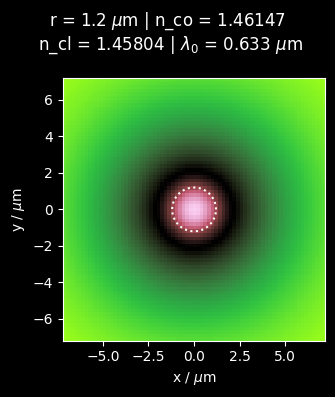

In [709]:
mode_files = modes['mode_files']
num_modes = len(mode_files)
full_title = 'r = {Core_radius} $\mu$m | n_co = {Core_index} \n n_cl = {Cladding_index} | $\lambda_0$ = {free_space_wavelength} $\mu$m'.format(**config)
num_cols = int(np.ceil(np.sqrt(num_modes)))
num_rows = int(np.ceil(num_modes/num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
if num_modes == 1:
    ax = np.array([ax])
if len(ax.shape) == 1:
    ax = ax.reshape((1,ax.shape[0]))
job = []
radius = config['Core_radius']
core_theta = np.linspace(0, 2*np.pi, 100)
core_x = radius*np.cos(core_theta)
core_y = radius*np.sin(core_theta)
for idx, filename in enumerate(mode_files):
    extent, lines, n_eff = load_mode_data(filename)
    row = idx // num_cols
    col = idx % num_cols
    ax[row,col].set_ylabel('y / $\mu$m')
    ax[row,col].set_xlabel('x / $\mu$m')
    ax[row,col].imshow(lines,
                extent=extent,
                cmap=cm.watermelon,
                aspect=1,
                origin='lower')
    ax[row,col].plot(core_x, core_y, 'w:')
    job.append((row,col))
for row in range(num_rows):
    for col in range(num_cols):
        if (row,col) not in job:
            ax[row,col].axis('off')
fig.suptitle(full_title)
plt.tight_layout()
plt.show()

In [706]:
def gaussian(x, *p):
    a, x0, sigma = p
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def besselian(x, *p):
    k = p
    return BesselJ(0, x * k)

def besselianK(x, *p):
    k, a = p
    return a*BesselK(0, x * k)

diameter_field = lines[lines.shape[0]//2,:]
diameter_power = diameter_field**2
r = np.linspace(extent[0],extent[1],lines.shape[1])
p0 = [1,0,1]
coeff, _ = curve_fit(gaussian, r, diameter_power, p0=p0)
_, _, sigma = coeff
MFD = 2*2*sigma
print("MFD = %.2f um" % MFD)

MFD2 = 2*np.interp([-1./np.e**2], -diameter_power[r>0], r[r>0])
print("MFD2 = %.2f um" % MFD2)

bessel_k, _ = curve_fit(besselian, r[np.abs(r)<config['Core_radius']], diameter_field[np.abs(r)<config['Core_radius']], p0=[1])
besselK_fit, _ = curve_fit(besselianK, r[r>config['Core_radius']], diameter_field[r>config['Core_radius']], p0=[1,2])

MFD = 5.87 um
MFD2 = 6.88 um


c:\Users\lab_pc_cryo\anaconda3\envs\rspie\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [707]:
bessel_k[0], besselK_fit[0]

(0.8078409759360937, 0.1603405961756793)

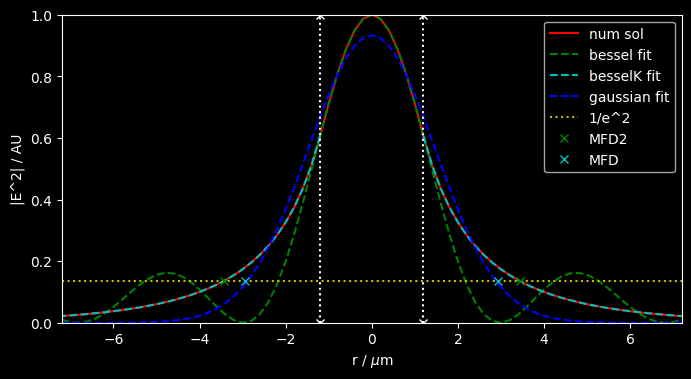

In [708]:
plt.figure(figsize=(8,4))
plt.plot(r, diameter_power, 'r-', label='num sol')
plt.plot(r, besselian(r, *(bessel_k))**2, 'g--', label='bessel fit')
plt.plot(r[r>config['Core_radius']], besselianK(r[r>config['Core_radius']], *besselK_fit)**2, 'c--', label='besselK fit')
plt.plot(-r[r>config['Core_radius']], besselianK(r[r>config['Core_radius']], *besselK_fit)**2, 'c--')
plt.plot(r, gaussian(r, *coeff), 'b--', label='gaussian fit')
plt.plot([-config['Core_radius'], -config['Core_radius']], [0,1], 'wx:')
plt.plot([config['Core_radius'], config['Core_radius']], [0,1], 'wx:')
plt.plot([r[0],r[-1]],[1/np.e**2,1/np.e**2],'y:', label='1/e^2')
plt.plot([-MFD2/2,MFD2/2],[1/np.e**2]*2,'gx', label='MFD2')
plt.plot([-MFD/2,MFD/2],[1/np.e**2]*2,'cx', label='MFD')
plt.ylim(0,1)
plt.xlim(r[0],r[-1])
plt.legend()
plt.xlabel('r / $\mu$m')
plt.ylabel('|E^2| / AU')
plt.show()

### ###Single Radius (semi-vector mode)

Radius of the core is not given in the spec sheet, this was approximated from their given MFD. However, this choice is not self-consistent. Also, it is not exactly clear what it is that they're quoting in the MFD. At the end this ends up being an example of a single-mode fiber, but not necessarily matching all of the ideal features of the SM600.

In [746]:
config = {'mode_set':'0-19',
        'prefix':'SM600-semi',
        'mode_method':'2',
        'vector': 2, # 0 for scalar, 1 for semi-vector, 2 for full-vector
        'polarization': 0, # 0 = TE, 1 = TM
        'free_space_wavelength'  : 0.633,
                'Core_radius'    : 1.2,
                'Core_index'     : 1.46147,
                'Cladding_index' : 1.45804,
        'comments': 'based on SM600 fiber from Thorlabs',
        'mode_output_format':'OUTPUT_REAL_IMAG',
        'launch_type':'LAUNCH_GAUSSIAN'}
simulscript = 'C:/Users/lab_pc_cryo/Documents/Photonic_Tools/fiber_modes/fiber_modes.ind'
modes = waveguide_modes(config, simulscript)

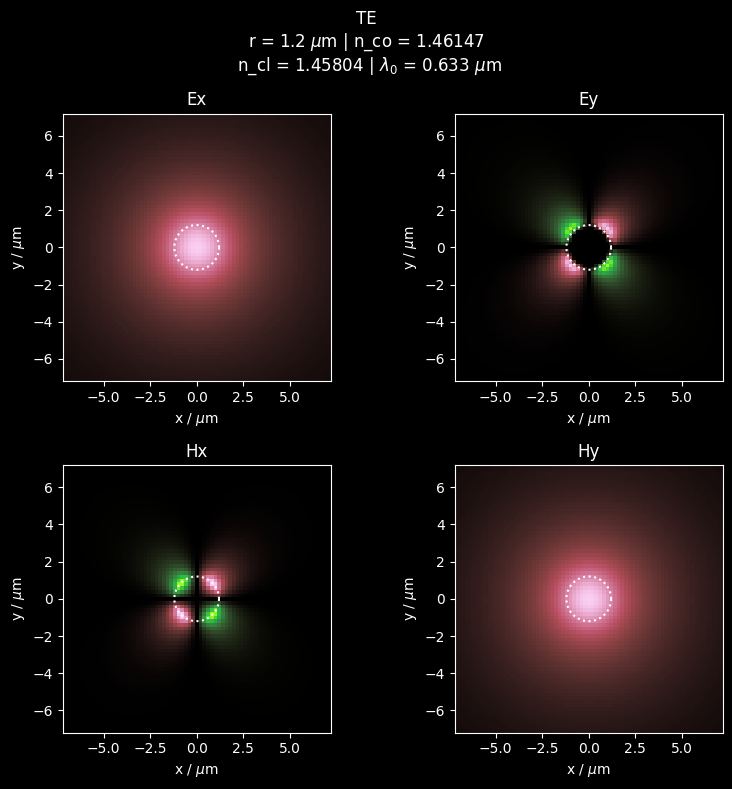

In [751]:
mode_files = modes['mode_files']
num_modes = len(mode_files)
full_title = 'r = {Core_radius} $\mu$m | n_co = {Core_index} \n n_cl = {Cladding_index} | $\lambda_0$ = {free_space_wavelength} $\mu$m'.format(**config)
num_cols = int(np.ceil(np.sqrt(num_modes)))
num_rows = int(np.ceil(num_modes/num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
if 'polarization' in config:
    if config['polarization'] == 0:
        pol = 'TE'
    elif config['polarization'] == 0:
        pol = 'TM'
    else:
        pol = ''
if num_modes == 1:
    ax = np.array([ax])
if len(ax.shape) == 1:
    ax = ax.reshape((1,ax.shape[0]))
job = []
radius = config['Core_radius']
core_theta = np.linspace(0, 2*np.pi, 100)
core_x = radius*np.cos(core_theta)
core_y = radius*np.sin(core_theta)
for idx, filename in enumerate(mode_files):
    extent, lines, n_eff = load_mode_data(filename)
    if '_ex' in filename:
        field_component = 'Ex'
    elif '_hy' in filename:
        field_component = 'Hy'
    elif '_ey' in filename:
        field_component = 'Ey'
    elif '_hx' in filename:
        field_component = 'Hx'
    else:
        field_component = ''
    row = idx // num_cols
    col = idx % num_cols
    ax[row,col].set_ylabel('y / $\mu$m')
    ax[row,col].set_xlabel('x / $\mu$m')
    map_normalizer = max(np.max(lines), abs(np.min(lines)))
    ax[row,col].imshow(lines,
                extent=extent,
                cmap=cm.watermelon,
                aspect=1,
                vmin=-map_normalizer,
                vmax=map_normalizer,
                origin='lower')
    ax[row,col].plot(core_x, core_y, 'w:')
    ax[row,col].set_title(field_component)
    job.append((row,col))
for row in range(num_rows):
    for col in range(num_cols):
        if (row,col) not in job:
            ax[row,col].axis('off')
fig.suptitle('TE\n'+full_title)
plt.tight_layout()
plt.show()

In [752]:
def gaussian(x, *p):
    a, x0, sigma = p
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def besselian(x, *p):
    k = p
    return BesselJ(0, x * k)

def besselianK(x, *p):
    k, a = p
    return a*BesselK(0, x * k)

diameter_field = lines[lines.shape[0]//2,:]
diameter_power = diameter_field**2
r = np.linspace(extent[0],extent[1],lines.shape[1])
p0 = [1,0,1]
coeff, _ = curve_fit(gaussian, r, diameter_power, p0=p0)
_, _, sigma = coeff
MFD = 2*2*sigma
print("MFD = %.2f um" % MFD)

MFD2 = 2*np.interp([-1./np.e**2], -diameter_power[r>0], r[r>0])
print("MFD2 = %.2f um" % MFD2)

bessel_k, _ = curve_fit(besselian, r[np.abs(r)<config['Core_radius']], diameter_field[np.abs(r)<config['Core_radius']], p0=[0.2])
besselK_fit, _ = curve_fit(besselianK, r[r>config['Core_radius']], diameter_field[r>config['Core_radius']], p0=[1,2])

MFD = 5.88 um
MFD2 = 6.93 um


c:\Users\lab_pc_cryo\anaconda3\envs\rspie\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [753]:
bessel_k[0], besselK_fit[0]

(0.7971421506693652, 0.15935752495387084)

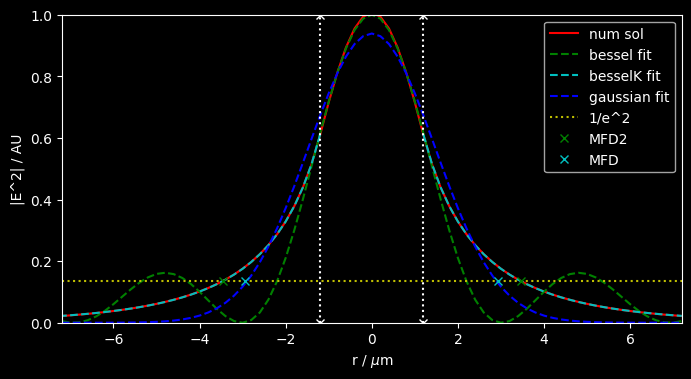

In [754]:
plt.figure(figsize=(8,4))
plt.plot(r, diameter_power, 'r-', label='num sol')
plt.plot(r, besselian(r, *(bessel_k))**2, 'g--', label='bessel fit')
plt.plot(r[r>config['Core_radius']], besselianK(r[r>config['Core_radius']], *besselK_fit)**2, 'c--', label='besselK fit')
plt.plot(-r[r>config['Core_radius']], besselianK(r[r>config['Core_radius']], *besselK_fit)**2, 'c--')
plt.plot(r, gaussian(r, *coeff), 'b--', label='gaussian fit')
plt.plot([-config['Core_radius'], -config['Core_radius']], [0,1], 'wx:')
plt.plot([config['Core_radius'], config['Core_radius']], [0,1], 'wx:')
plt.plot([r[0],r[-1]],[1/np.e**2,1/np.e**2],'y:', label='1/e^2')
plt.plot([-MFD2/2,MFD2/2],[1/np.e**2]*2,'gx', label='MFD2')
plt.plot([-MFD/2,MFD/2],[1/np.e**2]*2,'cx', label='MFD')
plt.ylim(0,1)
plt.xlim(r[0],r[-1])
plt.legend()
plt.xlabel('r / $\mu$m')
plt.ylabel('|E^2| / AU')
plt.show()

## ##Radius Sweep

In [395]:
radii = np.linspace(0.7,2,40)
MFDs = []
powers = []
diameters = []
for radius in radii:
    config = {'mode_set':'0-0',
            'prefix':'SM600',
            'mode_method':'2',
            'free_space_wavelength' : 0.633,
            'Core_radius'    : radius,
            'Core_index'     : 1.46147,
            'Cladding_index' : 1.45804,
            'comments': 'based on SM600 fiber from Thorlabs',
            'mode_output_format':'OUTPUT_REAL_IMAG',
            'launch_type':'LAUNCH_GAUSSIAN'}
    simulscript = 'C:/Users/lab_pc_cryo/Documents/Photonic_Tools/fiber_modes/fiber_modes.ind'
    modes = waveguide_modes(config, simulscript)
    mode_files = modes['mode_files']
    filename = mode_files[0]
    extent, lines, n_eff = load_mode_data(filename)
    diameter_power = lines[lines.shape[0]//2,:]**2
    powers.append(diameter_power)
    r = np.linspace(extent[0],extent[1],lines.shape[1])
    diameters.append(r)
    p0 = [1,0,1]
    coeff, _ = curve_fit(gaussian, r, diameter_power, p0=p0)
    _, _, sigma = coeff
    MFD = 2*2*sigma
    MFDs.append(MFD)

There should be about 0.2 modes.
There should be about 0.2 modes.
There should be about 0.2 modes.
There should be about 0.3 modes.
There should be about 0.3 modes.
There should be about 0.3 modes.
There should be about 0.3 modes.
There should be about 0.3 modes.
There should be about 0.4 modes.
There should be about 0.4 modes.
There should be about 0.4 modes.
There should be about 0.5 modes.
There should be about 0.5 modes.
There should be about 0.5 modes.
There should be about 0.5 modes.
There should be about 0.6 modes.
There should be about 0.6 modes.
There should be about 0.6 modes.
There should be about 0.7 modes.
There should be about 0.7 modes.
There should be about 0.7 modes.
There should be about 0.8 modes.
There should be about 0.8 modes.
There should be about 0.9 modes.
There should be about 0.9 modes.
There should be about 0.9 modes.
There should be about 1.0 modes.
There should be about 1.0 modes.
There should be about 1.1 modes.
There should be about 1.1 modes.
There shou

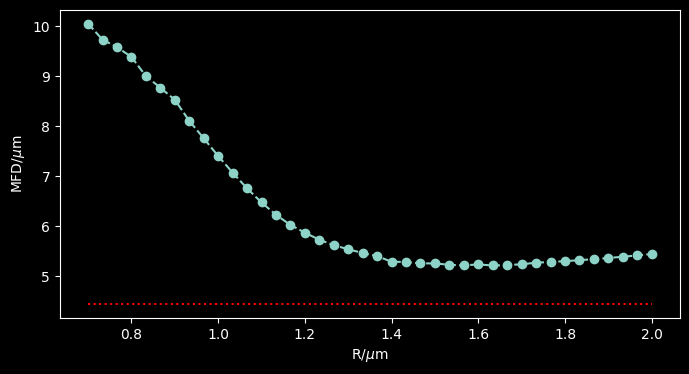

In [396]:
plt.figure(figsize=(8,4))
plt.plot(radii, MFDs,'o--')
plt.plot([radii[0],radii[-1]],[4.45]*2,'r:')
plt.xlabel('R/$\mu$m')
plt.ylabel('MFD/$\mu$m')
plt.show()

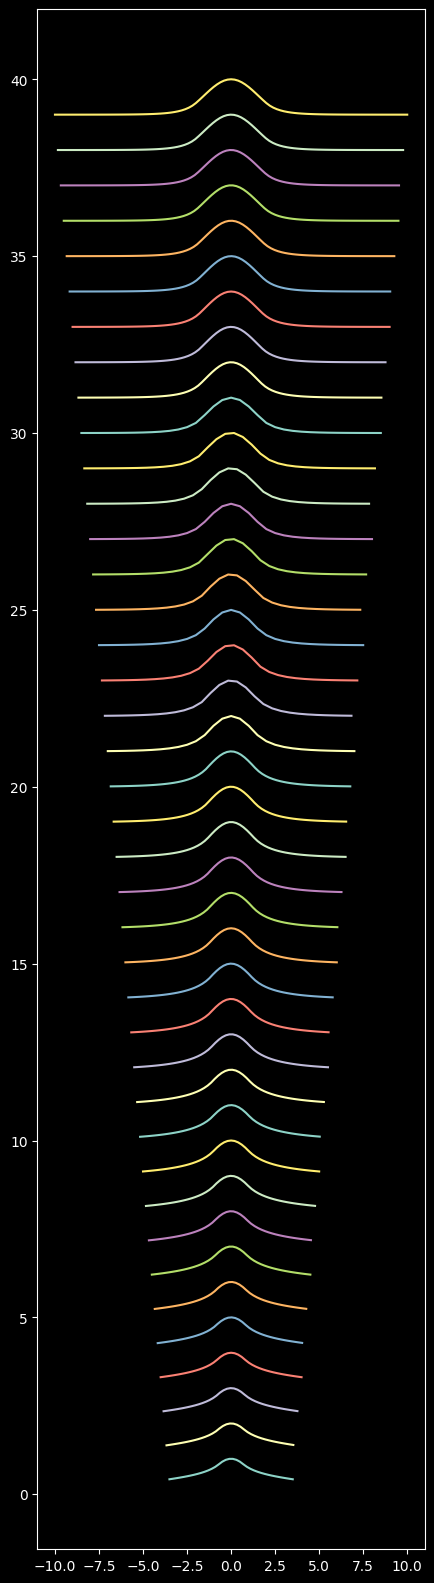

In [388]:
plt.figure(figsize=(5,20))
for idx, (r, p) in enumerate(zip(diameters, powers)):
    plt.plot(r, p+idx)
plt.show()

## ##Step - index optical fiber (Analytical solution)

$\left( \frac{n_1^2}{\gamma} \frac{J1}{J0} + \frac{n_2^2}{\beta} \frac{K1}{K0} \right)
\left( \frac{1}{\gamma} \frac{J1}{J0} + \frac{1}{\beta} \frac{K1}{K0} \right) = 
0$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


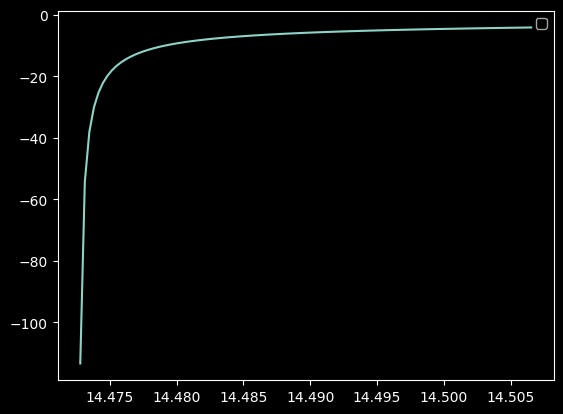

In [703]:
a = 1.2
n1 = 1.46147
n2 = 1.45804
λ = 0.633
k = 2*np.pi/λ
ω = k
kzs = np.linspace(0,100,400000)

γs2 = n1**2  * ω**2  - kzs**2
βs2 = kzs**2 - n2**2 * ω**2
kzs = kzs[(γs2 > 0) & (βs2 > 0)]
kzs = np.linspace(kzs[0],kzs[-1],100)
γs2 = n1**2  * ω**2  - kzs**2
βs2 = kzs**2 - n2**2 * ω**2
γs = np.sqrt(γs2)
βs = np.sqrt(βs2)

JpJ_ratio = BesselJp(0, γs * a) / BesselJ(0, γs * a)
KpK_ratio = BesselKp(0, βs * a) / BesselK(0, βs * a)

lhs1 = (n1**2 / γs * JpJ_ratio + n2**2 / βs * KpK_ratio)
sum(~np.isnan(lhs1))
plt.figure()
plt.plot(kzs, lhs1)
plt.legend()
plt.show()


### ###m != 0

$\left( \frac{n_1^2}{\gamma} \frac{Jm'}{Jm} + \frac{n_2^2}{\beta} \frac{Km'}{Km} \right)
\left( \frac{1}{\gamma} \frac{Jm'}{Jm} + \frac{1}{\beta} \frac{Km'}{Km} \right) = 
\frac{m^2}{a^2} \left(\frac{n_1^2}{\gamma^2} + \frac{n_2^2}{\beta^2} \right) 
\left(\frac{1}{\gamma^2} + \frac{1}{\beta^2}\right)$

It's not easy to understand what is to be solved in this equation.

We have n1, n2, m, a, \omega
We have to solve simultaneously of gamma and beta?
Not exactly gamma and beta are related to one another through kz. In reality the only unkown here is kz this is an equation with a single unkown kz.

Let's see if I can plot the RHS.

In [453]:
m = 3
a = 1.2
n1 = 1.6
n2 = 1.5
λ = 0.633
k = 2*np.pi/λ
ω = k
kzs = 2*np.pi / np.linspace(λ*0.5, λ*1.5, 1000)

γs = np.sqrt(n1**2 * ω**2 - kzs**2)
βs = np.sqrt(kzs**2 - n2**2 * ω**2)
rhs = m**2 / a**2 * (n1**2 / γs**2 + n2**2 / βs**2) * (1/γs**2 + 1/βs**2)

JpJ_ratio = BesselJp(m, γs * a) / BesselJ(m, γs * a)
KpK_ratio = BesselKp(m, βs * a) / BesselK(m, βs * a)

lhs = (
    (n1**2/γs * JpJ_ratio + n2**2/βs * KpK_ratio)
  * (1/γs * JpJ_ratio + 1/βs * KpK_ratio)
  )


C:\Users\lab_pc_cryo\AppData\Local\Temp\ipykernel_15260\3288525721.py:10: RuntimeWarning: invalid value encountered in sqrt
  γs = np.sqrt(n1**2 * ω**2 - kzs**2)
C:\Users\lab_pc_cryo\AppData\Local\Temp\ipykernel_15260\3288525721.py:11: RuntimeWarning: invalid value encountered in sqrt
  βs = np.sqrt(kzs**2 - n2**2 * ω**2)


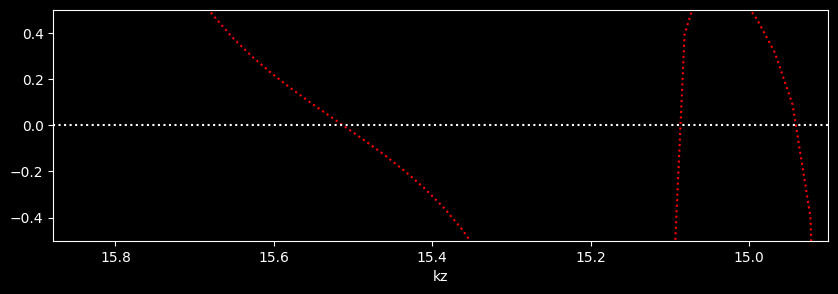

In [454]:
diff = rhs - lhs
good_k_boo = ~np.isnan(diff)
diff = diff[good_k_boo]
good_kz = kzs[good_k_boo]
plt.figure(figsize=(10,3))
plt.plot(good_kz, diff, 'r:')
plt.plot([good_kz[0], good_kz[-1]], [0,0], 'w:')
plt.ylim(-0.5,0.5)
plt.xlim(good_kz[0], good_kz[-1])
plt.xlabel('kz')
plt.show()

In [ ]:
def step_index_mode(mode_type, r, n_core, n_cladding):
    '''
    This function returns a function that can be used to evaluate
    the fields of a step-index mode.
    Parameters
    ---------
    mode_type (tuple): (type, order)
    r (float): radius of the core
    n_core (float): index of the core
    n_cladding (float): index of the cladding
    wavelength (float): wavelength of the light in vacuum

    Returns
    -------
    function: a function that can be used to evaluate the fields
    '''
    type, order = mode_type
    if type == 'HE':
        assert n!= 0, 'n must be non-zero for HE modes'
        n, m = order
        def Ez(x, y):
            '''
            This function evaluates the fields of a step-index mode.
            Parameters
            ---------
            x (float): x coordinate
            y (float): y coordinate

            Returns
            -------
            tuple: (Ex, Ey, Ez, Hx, Hy, Hz)
            '''
            return BesselJ(n, )
